In [1]:
from fun.show_histograms import *

In [2]:
folder = r'./data/fixation_over_time'
new_folder_names = ['WM_3', 'WM_10', 'WM_14']

### 1. Extract the polarimetric parameters in two ROIs

In [3]:
wavelength = '550'
data_all_combined = {}
raw_data_combined = {}

for new_folder_name in new_folder_names:
    
    for f in [os.listdir(folder)[0], os.listdir(folder)[8]]:

        if 'T0_' in f:

            path_res = os.path.join(folder, f, 'polarimetry', str(wavelength) + 'nm', '50x50_images', new_folder_name)
            mat = load_data_mm(os.path.join(folder, f), wavelength)[-1]

            with open(os.path.join(path_res, 'coordinates.txt')) as f:
                coordinates = f.readlines()

            xs, ys = [], []
            for idx, coord in enumerate(coordinates):
                num_coord = int(coord.replace('\n', ''))
                if idx <= 1:
                    ys.append(num_coord)
                else:
                    xs.append(num_coord)

            data_all_combined[new_folder_name] = parameters_histograms(mat, xs, ys, path_res)

        else:

            path_res = os.path.join(folder, f, 'polarimetry', str(wavelength) + 'nm', '50x50_images', new_folder_name + '_align')
            with open(os.path.join(path_res, 'data_raw.pickle'), 'rb') as handle:
                raw_data_combined[new_folder_name] = pickle.load(handle)

In [4]:
parameters = {}

for new_folder_name in new_folder_names:
    # get the values for linear retardance, depolarization and azimuth before and after fixation
    linear_retardance_before = data_all_combined[new_folder_name]['linR']
    linear_retardance_after = raw_data_combined[new_folder_name][0][0][3]
    
    depolarization_before = data_all_combined[new_folder_name]['totP']
    depolarization_after = raw_data_combined[new_folder_name][0][3][3]
    
    azimuth_before = data_all_combined[new_folder_name]['azimuth']
    azimuth_after = raw_data_combined[new_folder_name][0][2][3]
    
    parameters[new_folder_name] = [[linear_retardance_before, linear_retardance_after], 
                                   [depolarization_before, depolarization_after],
                                   [azimuth_before, azimuth_after]]

### 2. Plot the distribution of the parameters in the ROIs

In [5]:
keys = ['Linear retardance (°)', 'Depolarization', 'Azimuth of optical axis (°)']

In [6]:
path_res = './results/histograms'

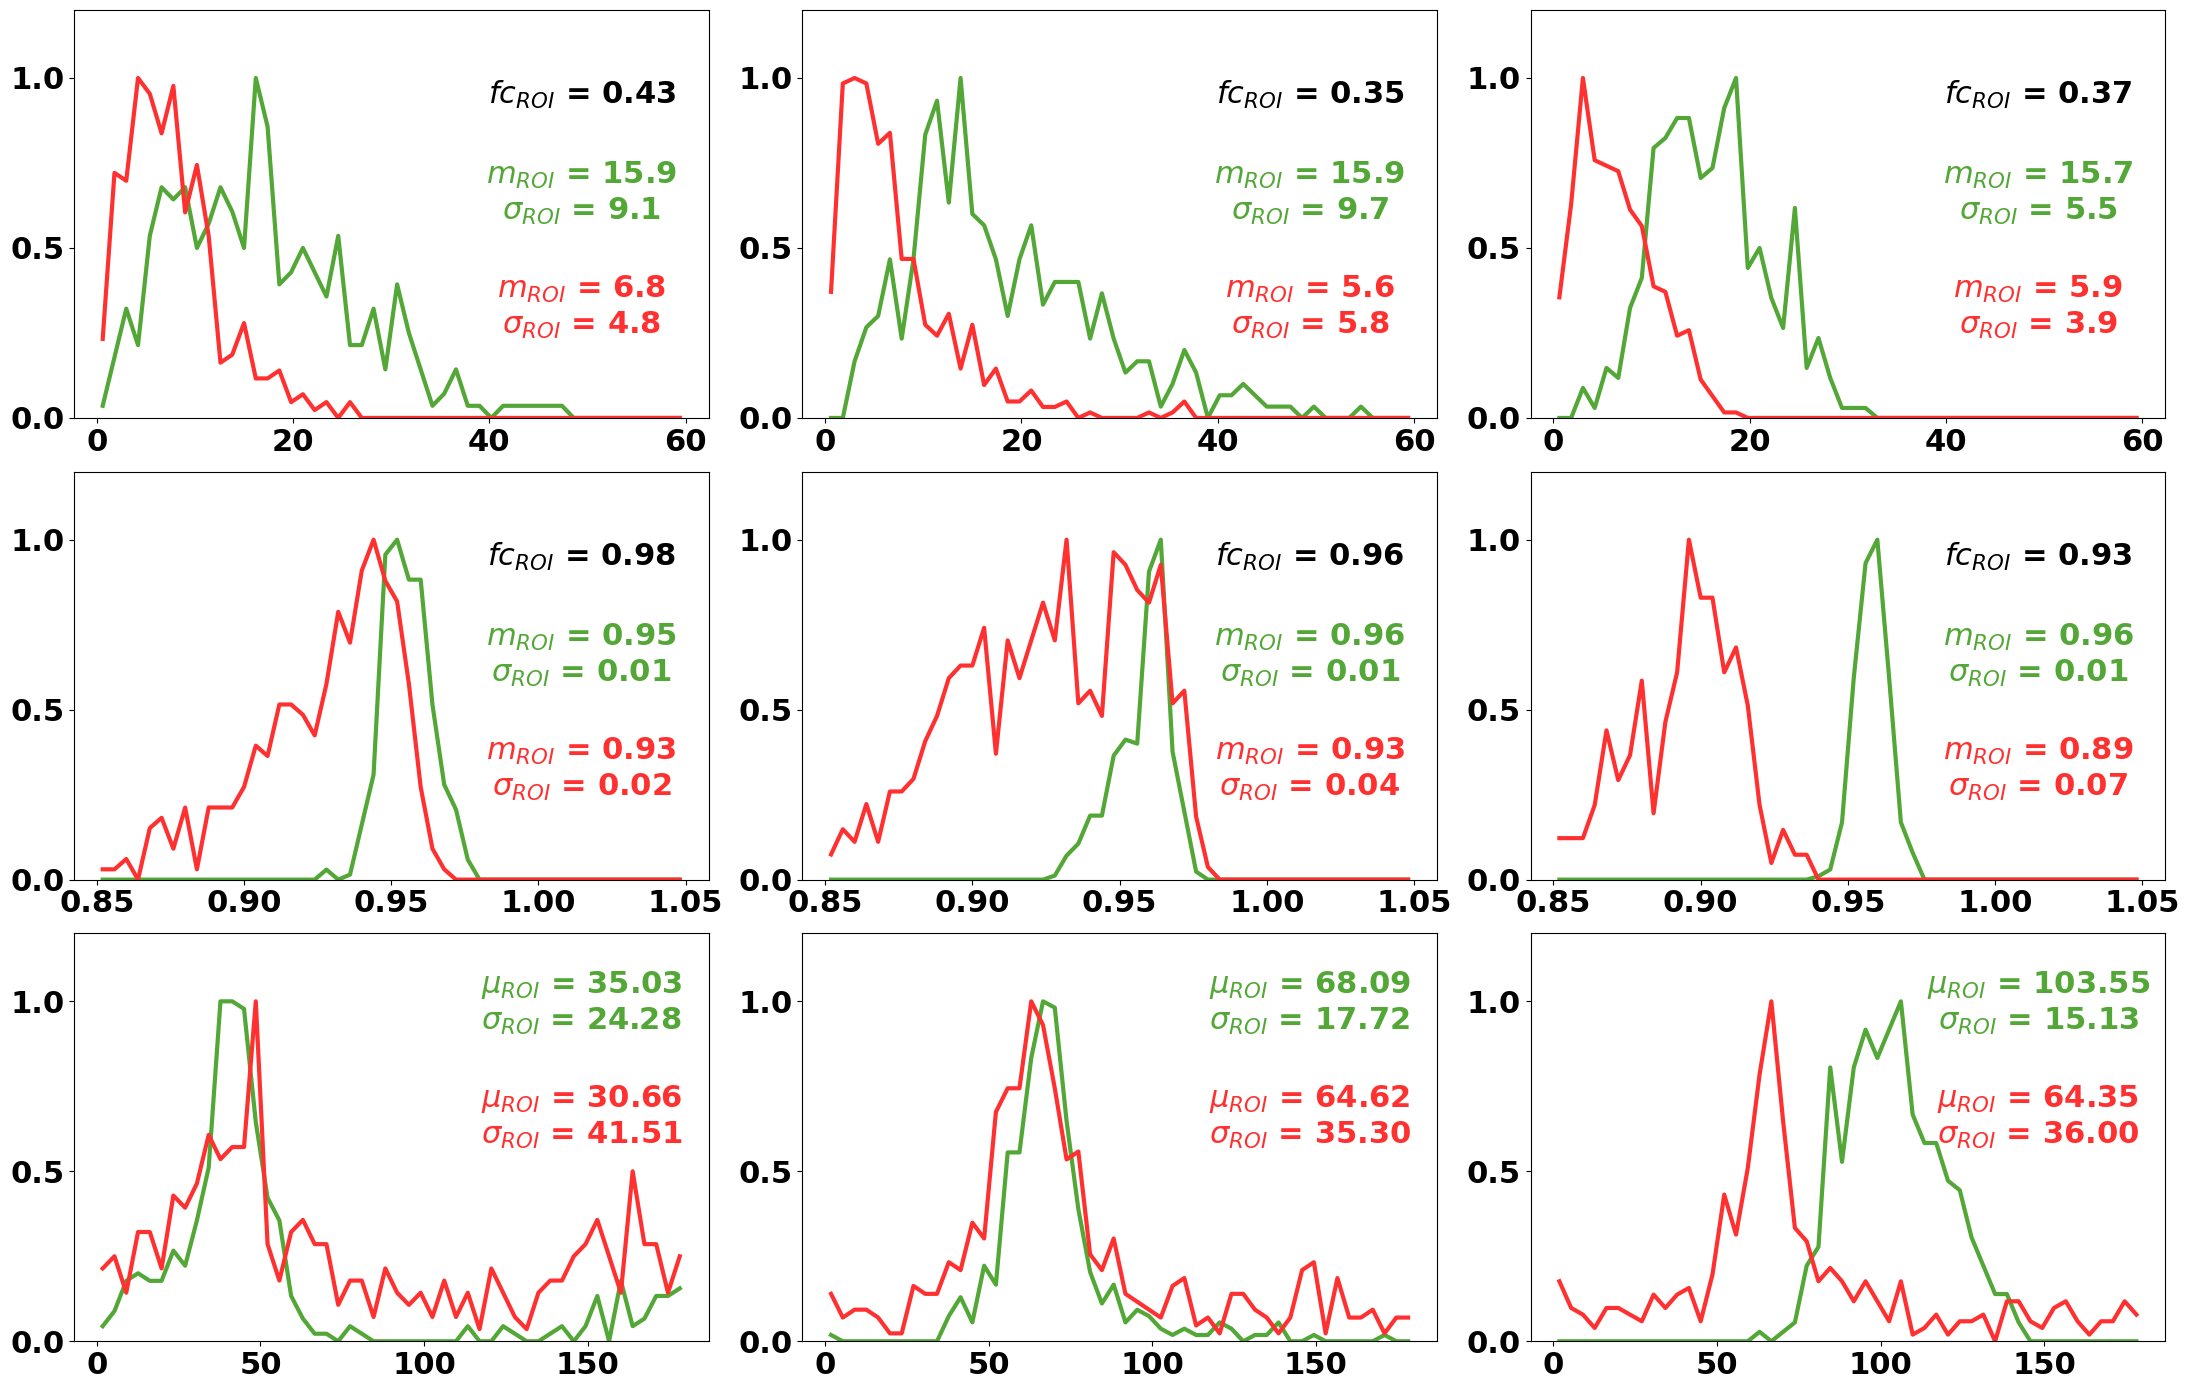

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(22,14))

for column, new_folder_name in enumerate(new_folder_names):
    for row, key, param in zip(range(0,3), keys, parameters[new_folder_name]):
        ax = axes[row, column]
    
        # change the range of the histograms
        if key == 'Depolarization':
            range_hist = (0.85, 1.05)
        elif key == 'Linear retardance (°)':
            range_hist = (0, 60)
        else:
            range_hist = (0, 180)

        for idx_p, vals in enumerate(param):
            y, x = np.histogram(
                vals,
                bins=50,
                density=False,
                range = range_hist)

            x_plot = []
            for idx, x_ in enumerate(x):
                try: 
                    x_plot.append((x[idx] + x[idx + 1]) / 2)
                except:
                    pass

            # get the mean, max and std
            max_ = x[np.argmax(y)]
            if key == 'Azimuth of optical axis (°)':
                mean = average_angles(vals)
                differences = []
                for v in vals:
                    differences.append(subtract_angle(mean, v) * subtract_angle(mean, v))
                std = np.sqrt(np.sum(differences)/len(differences))
            else:
                mean = np.nanmedian(vals)
                std = np.nanstd(vals)

            if idx_p == 0:
                mean_bf = mean
            else:
                mean_af = mean

            y = y / np.max(y)

            # plot the histogram
            if idx_p == 0:
                color = '#52a736'
                line1, = ax.plot(x_plot, y, c = color, linewidth=3)
            else:
                color = '#FF3030'
                line2, = ax.plot(x_plot, y, c = color, linewidth=3)


            ax.axis(ymin=0,ymax=1.2)
            ax.locator_params(axis='y', nbins=4)
            ax.locator_params(axis='x', nbins=5)


            if idx_p == 0:
                if key == 'Azimuth of optical axis (°)':
                    ax.text(0.80, 0.83, '$\mu_{ROI}$' + ' = {:.2f}\n'.format(mean) + '$\sigma_{ROI}$' + ' = {:.2f}'.format(std), 
                        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                        fontsize=22, fontweight = 'bold', c = color)
                else:
                    if key == 'Depolarization':
                        ax.text(0.80, 0.55, '$m_{ROI}$'+ ' = {:.2f}\n'.format(mean) + '$\sigma_{ROI}$'+' = {:.2f}'.format(std), 
                                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                                fontsize=22, fontweight = 'bold', c = color)
                    else:
                        ax.text(0.80, 0.55, '$m_{ROI}$'+ ' = {:.1f}\n'.format(mean) + '$\sigma_{ROI}$'+' = {:.1f}'.format(std), 
                                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                                fontsize=22, fontweight = 'bold', c = color)

            else:
                if key == 'Azimuth of optical axis (°)':
                    ax.text(0.80, 0.55, '$\mu_{ROI}$' + ' = {:.2f}\n'.format(mean) + '$\sigma_{ROI}$' + ' = {:.2f}'.format(std), 
                        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                        fontsize=22, fontweight = 'bold', c = color)
                else:
                    ax.text(0.80, 0.75, '$fc_{ROI}$'+ ' = {:.2f}\n'.format(mean / mean_bf), 
                            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                            fontsize=22, fontweight = 'bold')

                    if key == 'Depolarization':
                        ax.text(0.80, 0.27, '$m_{ROI}$'+ ' = {:.2f}\n'.format(mean) + '$\sigma_{ROI}$'+' = {:.2f}'.format(std), 
                            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                            fontsize=22, fontweight = 'bold', c = color)

                    else:
                        ax.text(0.80, 0.27, '$m_{ROI}$'+ ' = {:.1f}\n'.format(mean) + '$\sigma_{ROI}$'+' = {:.1f}'.format(std), 
                            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, 
                            fontsize=22, fontweight = 'bold', c = color)


        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(22)
            tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(22)
            tick.label1.set_fontweight('bold')

        # ax.set_title(param[0], fontdict = {'fontsize': 30, 'fontweight': 'bold'})
        # ax.set_ylabel('Normalized pixel number', fontdict = {'fontsize': 20, 'fontweight': 'bold'})

        # save the figures
        plt.tight_layout()
        legend_properties = {'weight':'bold', 'size': 22}

        # leg = ax.legend([line1, line2], ['Fresh tissue', 'Fixed tissue'], prop=legend_properties, loc = 2)
        # leg.get_frame().set_linewidth(0.0)
    
plt.savefig(os.path.join(path_res, 'summary_histo.pdf'))

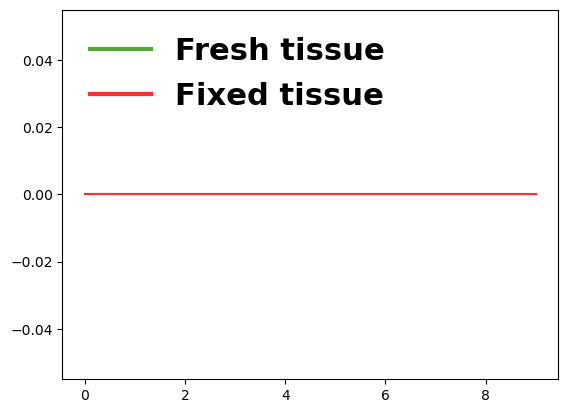

In [39]:
import random
import numpy as np


fig = plt.plot(range(10), [0 for i in range(10)], c = '#52a736')
fig = plt.plot(range(10), [0 for i in range(10)], c = '#FF3030')
ax = plt.gca()
legend_properties = {'weight':'bold', 'size': 22}
leg = ax.legend([line1, line2], ['Fresh tissue', 'Fixed tissue'], prop=legend_properties, loc = 2)
leg.get_frame().set_linewidth(0.0)
plt.savefig(os.path.join(path_res, 'legend_histo.pdf'))